In [30]:
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_default_device',jax.devices()[-1])
import jax.numpy as jnp
import optax
import jax
import numpy as np
from stochastic_interpolant.neural_network import NeuralNetwork
from stochastic_interpolant.dataloaders import (
    DatasetSampler,GaussianReferenceSampler,
    IndependenceCouplingSampler,build_trainloader,testloader_factory)
from stochastic_interpolant.loss_functions import get_trig_interpolants,root_prod_gamma,root_prod_gammadot,get_loss_functions
from stochastic_interpolant.data_generators import inf_train_gen
from stochastic_interpolant.model_training import train_model

In [25]:
import pandas as pd

bamdad = pd.read_csv("spell_data_bamdad.csv")[['x','y']].astype('float').values
jingwei = pd.read_csv("spell_data_jingwei.csv")[['x','y']].astype('float').values

stacked = np.vstack([bamdad,jingwei])
meanval = np.mean(stacked,axis=0)
scale = np.max(np.abs(stacked-meanval),axis=0)

bamdad = (bamdad - meanval)/scale
jingwei = (jingwei - meanval)/scale




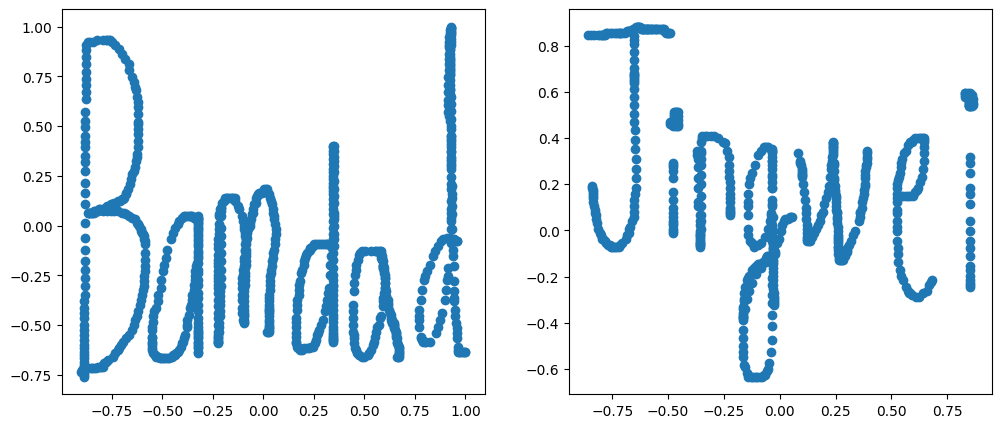

In [28]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(bamdad[:,0],bamdad[:,1])
plt.subplot(1,2,2)
plt.scatter(jingwei[:,0],jingwei[:,1])

In [31]:
reference_samples = bamdad
target_samples = jingwei

In [32]:
I,It = get_trig_interpolants()
gamma = root_prod_gamma
gammadot = root_prod_gammadot
loss_b,loss_denoise = get_loss_functions(I,It,gamma,gammadot)

b_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(21239)
)
eta_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(30238)
)

data_coupling_sampler = IndependenceCouplingSampler(
    DatasetSampler(reference_samples),
    DatasetSampler(target_samples)
    )
batch_size = 1024

train_loader = build_trainloader(batch_size,jax.random.PRNGKey(124),data_coupling_sampler)
test_factory = testloader_factory(batch_size,jax.random.PRNGKey(32498130),data_coupling_sampler)

In [33]:
b_optim = optax.nadamw(4e-4)

b_model,b_loss_history = train_model(
  model = b_model,
  optim = b_optim,
  steps = 100000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_b,
  print_every = 5000,
  num_testloader_batches = 100,
)


  0%|          | 0/100000 [00:00<?, ?it/s]

step=0 | train_loss=0.060451355 | test_loss= -0.09570752
step=5000 | train_loss=-2.4605615 | test_loss= -2.4148135
step=10000 | train_loss=-2.6031208 | test_loss= -2.666645
step=15000 | train_loss=-2.731515 | test_loss= -2.887322
step=20000 | train_loss=-3.250639 | test_loss= -2.9681695
step=25000 | train_loss=-3.0966365 | test_loss= -3.0529974
step=30000 | train_loss=-3.801849 | test_loss= -3.1251626
step=35000 | train_loss=-4.2292376 | test_loss= -3.0061328
step=40000 | train_loss=-3.0234566 | test_loss= -3.1334505
step=45000 | train_loss=-2.156766 | test_loss= -3.2811391
step=50000 | train_loss=-2.6940804 | test_loss= -3.2427814
step=55000 | train_loss=-4.0052347 | test_loss= -3.3206775
step=60000 | train_loss=-3.2279387 | test_loss= -3.329652
step=65000 | train_loss=-1.8488631 | test_loss= -3.3057013
step=70000 | train_loss=-2.1653428 | test_loss= -3.32766
step=75000 | train_loss=-2.109348 | test_loss= -3.3967466
step=80000 | train_loss=-3.3581583 | test_loss= -3.4177542
step=85000

In [34]:
eta_optim = optax.nadamw(4e-4)

eta_model,eta_loss_history = train_model(
  model = eta_model,
  optim = eta_optim,
  steps = 100000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_denoise,
  print_every = 5000,
  num_testloader_batches = 100,
)

  0%|          | 0/100000 [00:00<?, ?it/s]

step=0 | train_loss=0.14518754 | test_loss= -0.302802
step=5000 | train_loss=-1.123853 | test_loss= -1.1731476
step=10000 | train_loss=-1.165854 | test_loss= -1.185939
step=15000 | train_loss=-1.2364364 | test_loss= -1.1864221
step=20000 | train_loss=-1.2322594 | test_loss= -1.1906226
step=25000 | train_loss=-1.1450533 | test_loss= -1.1930417
step=30000 | train_loss=-1.1193252 | test_loss= -1.1932182
step=35000 | train_loss=-1.1931074 | test_loss= -1.19392
step=40000 | train_loss=-1.2589062 | test_loss= -1.194334
step=45000 | train_loss=-1.287173 | test_loss= -1.1952763
step=50000 | train_loss=-1.2930739 | test_loss= -1.1949612
step=55000 | train_loss=-1.12487 | test_loss= -1.1959995
step=60000 | train_loss=-1.2050943 | test_loss= -1.1967896
step=65000 | train_loss=-1.0889695 | test_loss= -1.1955438
step=70000 | train_loss=-1.2556275 | test_loss= -1.1961124
step=75000 | train_loss=-1.2990894 | test_loss= -1.1956575
step=80000 | train_loss=-1.1909192 | test_loss= -1.1959836
step=85000 |

In [42]:
from stochastic_interpolant.sampler import StochasticSampler
from diffrax import SaveAt

stochastic_sampler = StochasticSampler(gamma,b_model,eta_model)
X0 = bamdad
saveat = SaveAt(
    ts = jnp.linspace(0,1,50),
    dense = True
)
X1,sol = stochastic_sampler.sample_trajectory(X0,eps = 0.1,dt0 = 1e-4,saveat=saveat)

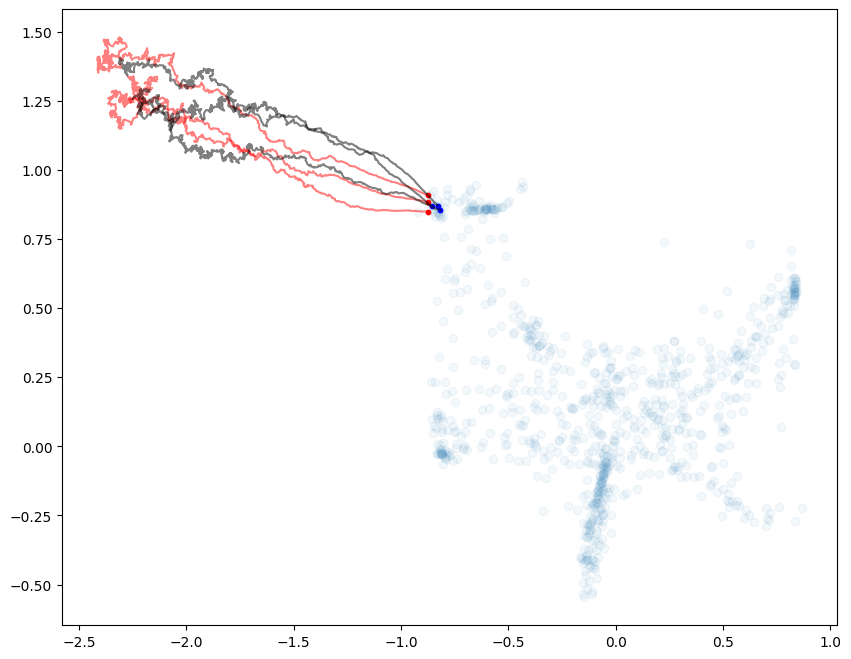

In [44]:
num_trajectories = 3

time_points = np.linspace(0,0.5,500)
plt.figure(figsize=(10,8))
plt.scatter(X1[:,0],X1[:,1],alpha = 0.05)

path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c = 'red',alpha = 0.5)

time_points = np.linspace(0.5,1.,500)
path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c='black',alpha = 0.5)

plt.scatter(X0[:num_trajectories,0],X0[:num_trajectories,1],c = 'red',s = 10.)

plt.scatter(X1[:num_trajectories,0],X1[:num_trajectories,1],c = 'blue',s = 10.)
plt.show()

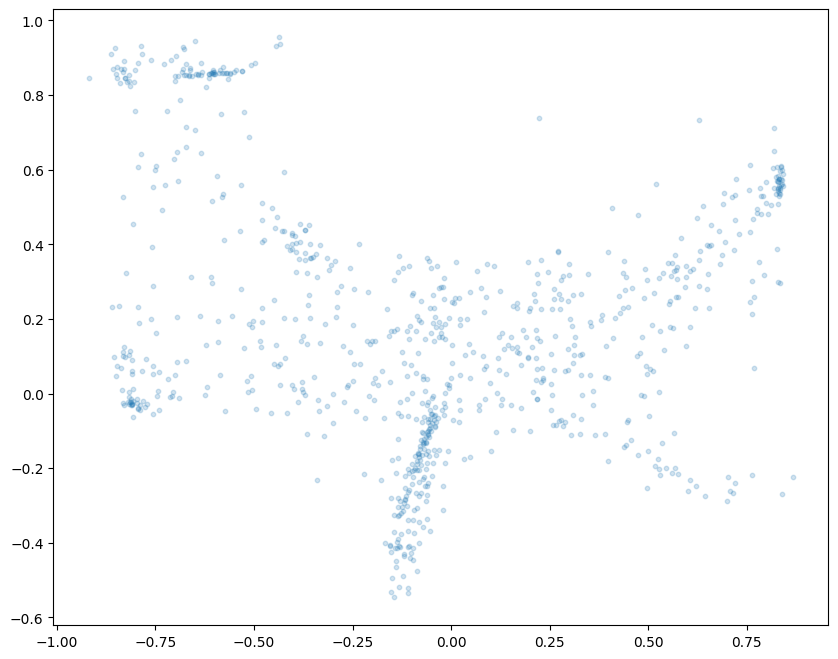

In [47]:
plt.figure(figsize=(10,8))
plt.scatter(X1[:,0],X1[:,1],alpha = 0.2, s = 10)
plt.scatter(target_samples[:,0],target_samples[:,1],alpha = 0.2,c = 'red', s = 2)